In [104]:
# Credit for tabpfn usage and parameters goes to VADIM KAMAEV and Samuel
# Balanced log loss from DANIEL DEWEY
# Still experimenting with xgb but results are weaker compared to tabpfn

In [105]:
import sys
import sklearn
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import torch

In [106]:
# UNCOMMENT first with internet option turned on
# Use GPU env

#!pip download tabpfn --no-deps -d pip-packages
#!pip install tabpfn
#from tabpfn import TabPFNClassifier
#TabPFNClassifier(N_ensemble_configurations=64,device='cuda:0')

#!mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
#!zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [107]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

Looking in links: file:///kaggle/input/pip-packages-icr/pip-packages


In [108]:
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [109]:
filepath = '/kaggle/input/icr-identify-age-related-conditions/'
train = pd.read_csv(os.path.join(filepath, 'train.csv'))
test = pd.read_csv(os.path.join(filepath, 'test.csv'))
greeks = pd.read_csv(f'{filepath}greeks.csv')

In [110]:
train.head(10)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
5,04517a3c90bd,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,...,0.173229,0.49706,1.164956,21.915512,72.611063,24177.595550,28.525186,82.527764,21.978000,0
6,049232ca8356,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,...,4.408484,0.86130,0.467337,17.878444,192.453107,3332.467494,34.166222,100.086808,0.065096,0
7,057287f2da6d,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,...,6.591896,0.49706,0.277693,18.445866,109.693986,21371.759850,35.208102,31.424696,0.092873,0
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416,0
9,05f2bc0155cd,0.324748,5188.68207,85.200147,12.968687,8.138688,4.593392,0.025578,10.685041,1.229900,...,0.173229,1.57151,0.318331,24.515421,98.929757,5563.130949,21.994831,33.300970,21.978000,0


In [111]:
greeks.head(10)

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
5,04517a3c90bd,A,C,M,B,10/1/2019
6,049232ca8356,A,C,M,B,5/29/2019
7,057287f2da6d,A,C,M,B,4/24/2019
8,0594b00fb30a,A,C,M,B,2/18/2019
9,05f2bc0155cd,A,B,M,B,6/19/2020


In [112]:
test.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
train.dtypes

Id        object
AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EJ        object
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
dtype: object

In [114]:
# We see EJ is object type
print(train.EJ)

0      B
1      A
2      B
3      B
4      B
      ..
612    A
613    B
614    A
615    B
616    A
Name: EJ, Length: 617, dtype: object


In [115]:
train['EJ'].replace({'A':0, 'B':1}, inplace=True)
test['EJ'].replace({'A':0, 'B':1}, inplace=True)

/tmp/ipykernel_28/1303533406.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, cmap="coolwarm")


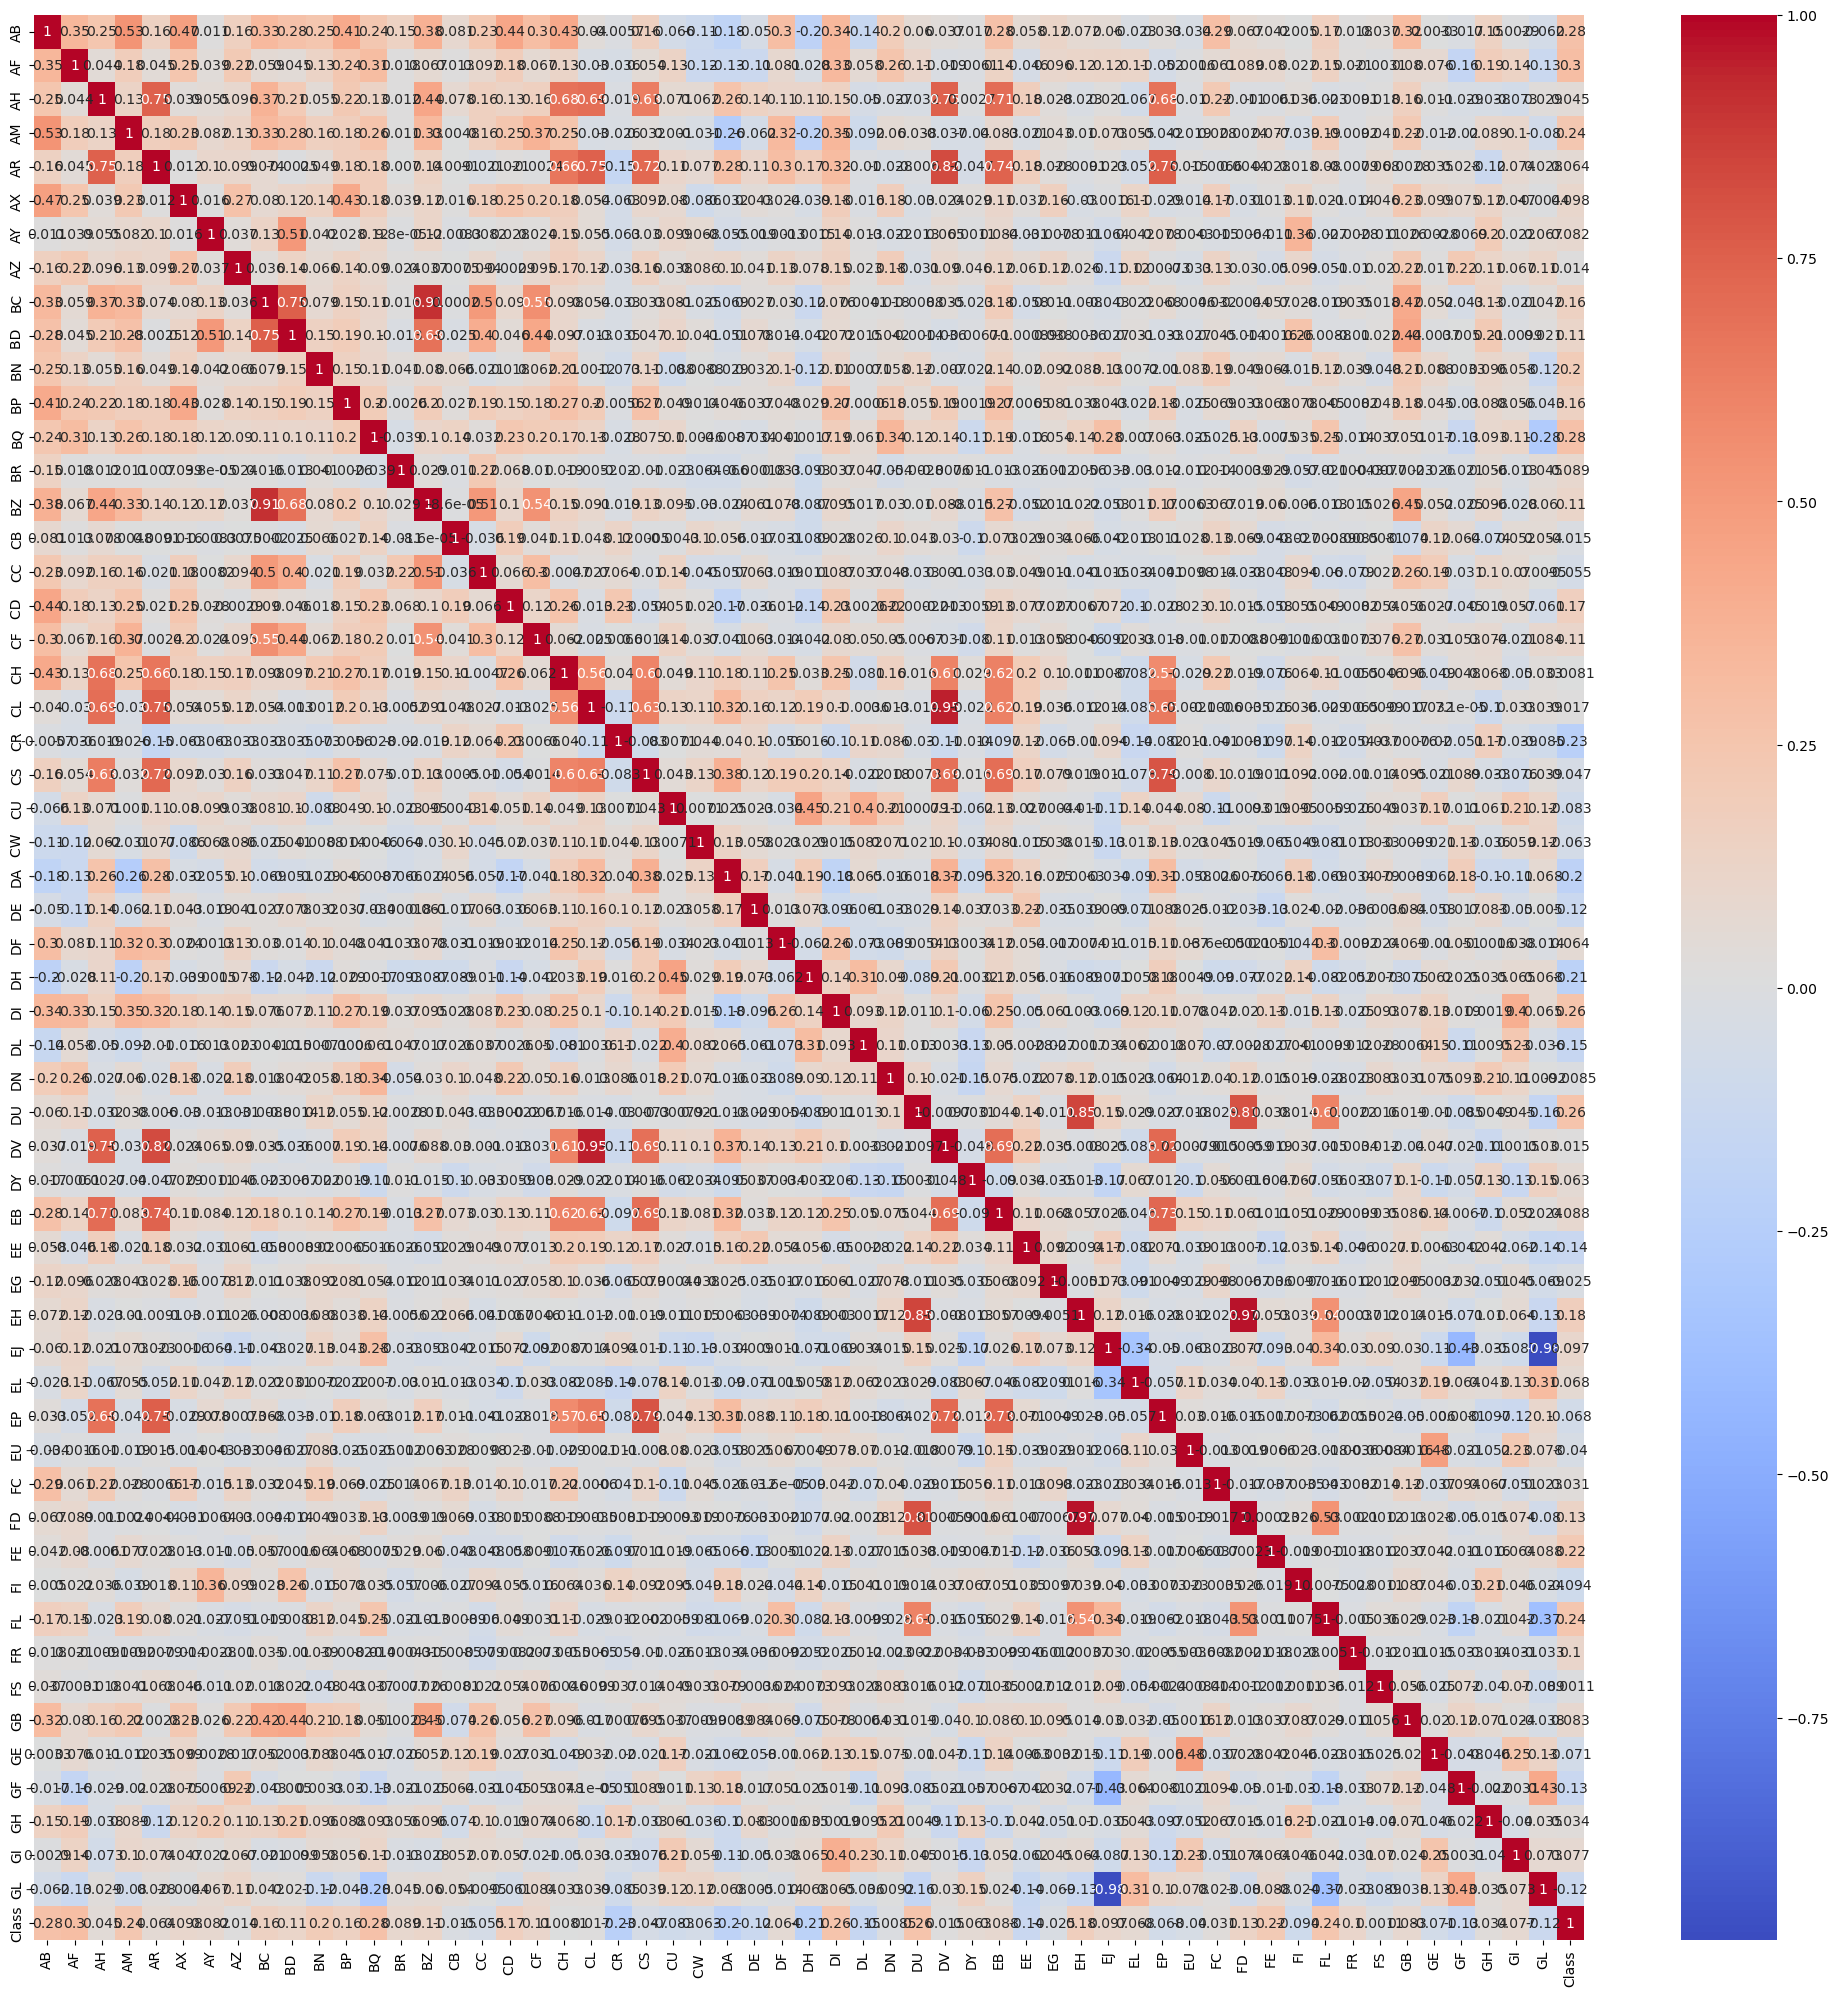

/tmp/ipykernel_28/1303533406.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr()[['Class']].sort_values(by='Class', ascending=False), annot = True, cmap="coolwarm")


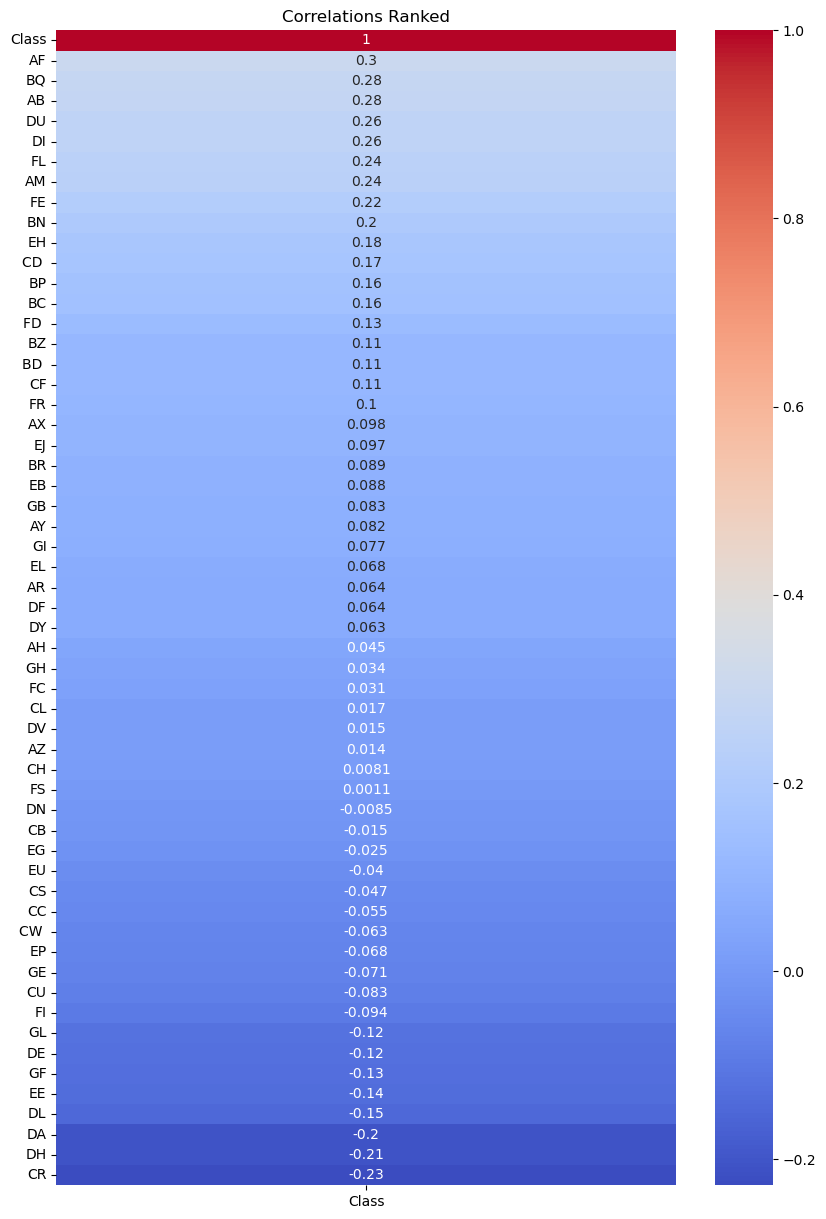

In [116]:
plt.figure(figsize = (25,25))
sns.heatmap(train.corr(), annot=True, cmap="coolwarm")
plt.show()

plt.figure(figsize = (10,15))
sns.heatmap(train.corr()[['Class']].sort_values(by='Class', ascending=False), annot = True, cmap="coolwarm")
plt.title('Correlations Ranked')
plt.show()

In [117]:
# see top 20 strongest correalations (absolute value of them)
train.corr().abs().unstack().sort_values(ascending = False).drop_duplicates().head(20)

/tmp/ipykernel_28/1152153300.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr().abs().unstack().sort_values(ascending = False).drop_duplicates().head(20)


AB   AB     1.000000
GL   EJ     0.978213
EH   FD     0.971152
CL   DV     0.948991
BZ   BC     0.907981
EH   DU     0.850957
AR   DV     0.823012
FD   DU     0.805989
EP   CS     0.794158
     AR     0.754615
BD   BC     0.753051
AR   AH     0.749794
AH   DV     0.746715
AR   CL     0.745504
     EB     0.741000
EP   EB     0.729374
AR   CS     0.720853
DV   EP     0.716778
AH   EB     0.705110
CS   EB     0.694716
dtype: float64

In [118]:
train.corr().unstack().sort_values(ascending = False).drop_duplicates().head(20)

/tmp/ipykernel_28/1382278973.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr().unstack().sort_values(ascending = False).drop_duplicates().head(20)


AB   AB     1.000000
FD   EH     0.971152
DV   CL     0.948991
BC   BZ     0.907981
EH   DU     0.850957
AR   DV     0.823012
DU   FD     0.805989
CS   EP     0.794158
AR   EP     0.754615
BD   BC     0.753051
AH   AR     0.749794
DV   AH     0.746715
CL   AR     0.745504
AR   EB     0.741000
EP   EB     0.729374
AR   CS     0.720853
EP   DV     0.716778
EB   AH     0.705110
CS   EB     0.694716
AH   CL     0.693637
dtype: float64

In [119]:
train.corr().unstack().sort_values(ascending = True).drop_duplicates().head(20)

/tmp/ipykernel_28/416655573.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr().unstack().sort_values(ascending = True).drop_duplicates().head(20)


EJ     GL   -0.978213
GF     EJ   -0.429403
FL     GL   -0.370082
EL     EJ   -0.336702
GL     BQ   -0.279813
AM     DA   -0.255359
Class  CR   -0.227547
       DH   -0.206839
       DA   -0.204612
AB     DH   -0.204446
AM     DH   -0.202972
AB     DA   -0.183127
DA     DI   -0.182527
GF     FL   -0.181186
CD     DA   -0.172518
EJ     DY   -0.167320
DU     GL   -0.162444
AF     GF   -0.159796
AR     CR   -0.153166
DN     DY   -0.149555
dtype: float64

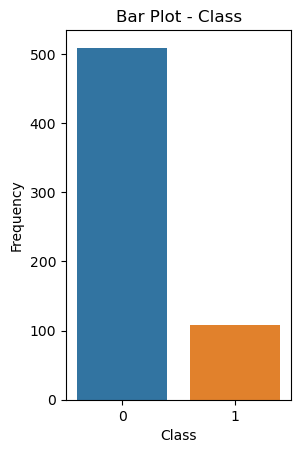

In [120]:
plt.subplot(1, 2, 1)
sns.countplot(data=train, x="Class")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Bar Plot - Class")
plt.show()

In [121]:
y = train['Class']
X = train.drop(['Id', 'Class'], axis=1)

ids = test['Id']
test = test.drop(['Id'], axis=1)

In [122]:
# Episilon from greeks has some useful time features
from datetime import date, datetime
times = greeks.Epsilon.copy()
times[greeks.Epsilon != 'Unknown'] = greeks.Epsilon[greeks.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks.Epsilon == 'Unknown'] = np.nan

In [123]:
X = pd.concat((X, times), 1)
X.head()

/tmp/ipykernel_28/2065713551.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  X = pd.concat((X, times), 1)


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Epsilon
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,737137.0
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,NaN
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,NaN
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,NaN
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,737509.0


In [124]:
test_predictors = np.array(test)
test_and_time = np.concatenate((test_predictors, np.zeros((len(test_predictors),1)) + X.Epsilon.max()+1),1)
test = pd.DataFrame(test_and_time, columns=X.columns)
test.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Epsilon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0


In [125]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier


class Ensemble():
    def __init__(self):
        self.classifiers = [XGBClassifier(colsample_bylevel = .6, colsample_bytree = 1.0, max_depth = 2, scale_pos_weight = 5,
                                          n_estimators = 300,learning_rate = 0.2,subsample = 1),
                            TabPFNClassifier(N_ensemble_configurations=64,device='cuda:0')]
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median')
    
    def fit(self, X, y):
        cls, y = np.unique(y, return_inverse=True)
        self.classes_ = cls
        X = self.imp.fit_transform(X)
        for cl in self.classifiers:
            cl.fit(X,y)
    
    def predict_proba(self, X):
        X = self.imp.transform(X)
        ps = np.stack([cl.predict_proba(X) for cl in self.classifiers])
        p = np.mean(ps,axis=0)
        class_0_est_instances = p[:,0].sum()
        others_est_instances = p[:,1:].sum()
        # we reweight the probs, since the loss is also balanced like this
        # our models out of the box optimize CE
        # with these changes they optimize balanced CE
        new_p = p * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(p.shape[1])]])
        return new_p / np.sum(new_p,axis=1,keepdims=1)

In [126]:
# Balanced log loss function from DANIEL DEWEY
# slightly modified from
# https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/409691
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

In [127]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

model = Ensemble()
loss_scores = list()
best_loss = np.inf

for train_ix, valid_ix in skf.split(X, y):
    X_train, X_valid = X.iloc[train_ix], X.iloc[valid_ix]
    y_train, y_valid = y.iloc[train_ix], y.iloc[valid_ix]
    
    model.fit(X_train, np.ravel(y_train)) 
    yhat = model.predict_proba(X_valid)
    
    # need to define / test thresholds to see validility and improvement, use log loss as our metric
    # thresholds were from VADIM KAMAEV
    probabilities = np.concatenate((yhat[:,:1], np.sum(yhat[:,1:], 1, keepdims=True)), axis=1)
    p0 = probabilities[:,:1]
    p0[p0 > 0.86] = 1
    p0[p0 < 0.14] = 0
    y_p = np.empty((yhat.shape[0],))
    for i in range(yhat.shape[0]):
        if p0[i]>=0.5:
            y_p[i]= False
        else :
            y_p[i]=True
    y_p = y_p.astype(int)
    loss = balanced_log_loss(y_valid,y_p)

    if loss < best_loss:
        best_model = model
        best_loss = loss
        print('best_model_saved')
    loss_scores.append(loss)


print('All Losses:', loss_scores)
print('Loss Mean:', np.mean(loss_scores))
print('Best Loss:', best_loss)
    

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
best_model_saved
best_model_saved
best_model_saved
All Losses: [0.7907082953501559, 1.7071898750278067, 1.1860624430252336, 0.9883853691876945, 1.3118357273527292, 1.3118357273527292, 0.3953541476750783, 1.1324236257249582, 0.37129348016491187, 0.9282337004122786]
Loss Mean: 1.0123322391273575
Best Loss: 0.37129348016491187


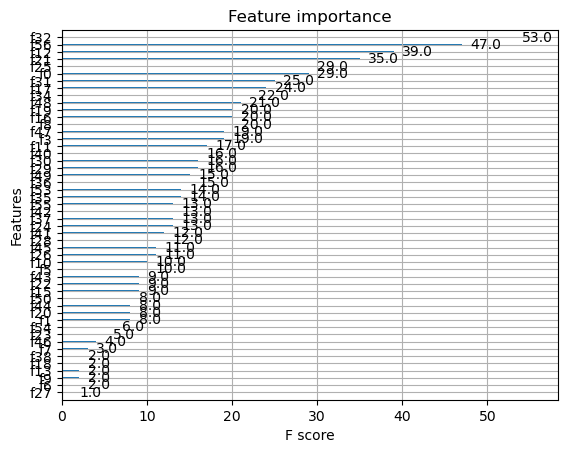

In [128]:
from xgboost import plot_importance

plot_importance(model.classifiers[0])
plt.show()

#maybe drop those with less than 10 F score

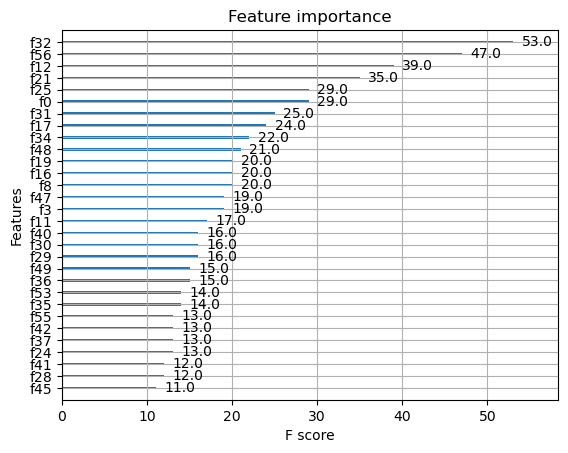

In [129]:
plot_importance(model.classifiers[0], max_num_features=30)
plt.show()

<Axes: >

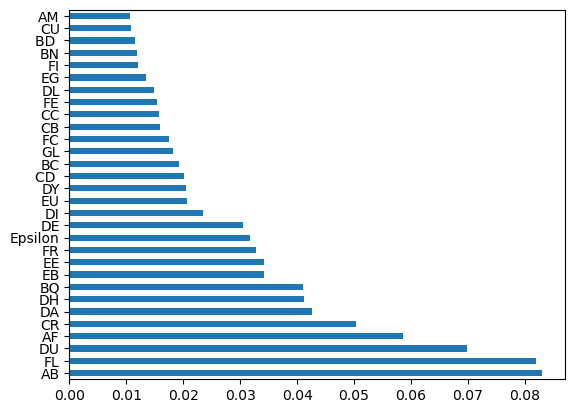

In [130]:
feature_importance = pd.Series(model.classifiers[0].feature_importances_, index=X.columns)
feature_importance.nlargest(30).plot(kind='barh')

In [131]:
new_features = feature_importance.nlargest(25)
new_features.keys()

Index(['AB', 'FL', 'DU', 'AF', 'CR', 'DA', 'DH', 'BQ', 'EB', 'EE', 'FR',
       'Epsilon', 'DE', 'DI', 'EU', 'DY', 'CD ', 'BC', 'GL', 'FC', 'CB', 'CC',
       'FE', 'DL', 'EG'],
      dtype='object')

In [132]:
X['Epsilon'] = X['Epsilon'].astype(float)
X2 = X[new_features.keys()]
X2

,AB,FL,DU,AF,CR,DA,DH,BQ,EB,EE,...,DY,CD,BC,GL,FC,CB,CC,FE,DL,EG
0,0.209377,7.298162,5.310690,3109.03329,0.069225,69.08340,0.284232,152.707705,7.294176,1.987283,...,23.187704,23.387600,5.555634,0.120343,13.394640,47.223358,0.563481,9028.291921,84.31664,1433.166750
1,0.145282,0.173229,0.005518,978.76416,1.117800,70.79836,0.363489,14.754720,4.926396,0.858603,...,17.222328,50.628208,1.229900,21.978000,17.175984,30.284345,0.484710,6785.003474,75.74548,1111.287150
2,0.470030,7.709560,1.289739,2635.10654,0.700350,70.81970,0.210441,219.320160,7.813674,8.146651,...,36.861352,85.955376,1.229900,0.196941,224.207424,32.563713,0.495852,8338.906181,65.46984,1494.076488
3,0.252107,6.122162,2.655345,3819.65177,0.636075,47.27586,0.292431,11.050410,7.386060,3.813326,...,52.003884,88.159360,1.229900,0.155829,59.301984,15.201914,0.717882,10965.766040,71.57120,15691.552180
4,0.380297,8.153058,1.144902,3733.04844,0.693150,74.06532,0.207708,149.717165,7.350720,3.490846,...,9.064856,72.644264,102.151980,0.096614,29.102640,82.213495,0.536467,16198.049590,52.83888,1403.656300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,0.173229,0.005518,3130.05946,0.698250,21.75904,0.445479,27.287375,8.015112,1.354416,...,32.508604,55.163024,2.804172,21.978000,29.708112,41.368691,0.691257,17167.209610,90.91832,495.086300
613,0.435846,10.223150,0.648318,5462.03438,0.761025,43.90996,0.437280,344.644105,8.976360,0.753797,...,18.197092,85.233928,3.777550,0.145340,69.343680,61.910576,0.772304,18460.330020,123.17624,1722.674025
614,0.427300,0.173229,0.005518,2459.10720,0.879825,104.62032,0.382620,103.988995,9.478188,2.225112,...,47.552312,142.680216,1.229900,21.978000,71.725584,90.411867,0.708616,5088.922912,326.23620,2565.402825
615,0.363205,9.256996,0.510378,1263.53524,0.583125,51.04140,0.549333,NaN,10.078968,1.628524,...,38.271840,122.939496,1.229900,0.184622,38.133312,12.499760,0.602254,6464.250832,96.97092,1318.962875


In [133]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

model2 = Ensemble()
loss_scores2 = list()
best_loss2 = np.inf

for train_ix, valid_ix in skf.split(X2, y):
    X_train, X_valid = X2.iloc[train_ix], X2.iloc[valid_ix]
    y_train, y_valid = y.iloc[train_ix], y.iloc[valid_ix]
    
    model2.fit(X_train, np.ravel(y_train)) 
    yhat = model2.predict_proba(X_valid)
    
    probabilities = np.concatenate((yhat[:,:1], np.sum(yhat[:,1:], 1, keepdims=True)), axis=1)
    p0 = probabilities[:,:1]
    p0[p0 > 0.86] = 1
    p0[p0 < 0.14] = 0
    y_p = np.empty((yhat.shape[0],))
    for i in range(yhat.shape[0]):
        if p0[i]>=0.5:
            y_p[i]= False
        else :
            y_p[i]=True
    y_p = y_p.astype(int)
    loss2 = balanced_log_loss(y_valid,y_p)

    if loss2 < best_loss2:
        best_model2 = model2
        best_loss2 = loss2
        print('best_model_saved')
    loss_scores2.append(loss2)


print('All Losses:', loss_scores2)
print('Loss Mean:', np.mean(loss_scores2))
print('Best Loss:', best_loss2)

# it seems like cutting features did not signficantly change, much less improve, our accuracy
# however, we try to progress with this anyway

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
best_model_saved
best_model_saved
best_model_saved
best_model_saved
All Losses: [2.4259943808679183, 1.9048669488653456, 0.7907082953501559, 0.3953541476750783, 0.593031221512617, 2.4259943808679183, 0.3953541476750783, 1.3366350398156595, 0.5569402202473674, 1.8750101562792203]
Loss Mean: 1.2699888939156359
Best Loss: 0.3953541476750783


In [135]:
test['Epsilon'] = test['Epsilon'].astype(float)
test = test[new_features.keys()]
test

,AB,FL,DU,AF,CR,DA,DH,BQ,EB,EE,...,DY,CD,BC,GL,FC,CB,CC,FE,DL,EG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
predictions = best_model2.predict_proba(test)
submit = pd.DataFrame(predictions, columns = ['class_0','class_1'])

submit['Id'] = ids
submit = submit[['Id','class_0','class_1']]

submit.head()

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [139]:
submit.to_csv('submission.csv', index=False)